# Introduction
Branches in CPU instructions are often a major reason for performance hits as work done in parts of the CPU pipeline has to be discarded and the target instruction address of the branch has to be calculated and fetched. As modern pipelines get more complicated, the slow down caused by branches increases. There are many different ways to lessen the impact of branching, such as a branch delay slot, multiple instruction streams and branch prediction. 

In this practical, we focus on different branch prediction strategies by writing a branch predictor simulator to simulate the strategies over a series of execution traces from benchmark programs and calculate the misprediction rates. The results are then presented and analysed to understand the effectiveness of different strategies on different types of programs. 

The following branch prediction strategies were simulated and analysed:
- Always taken
- Always not taken
- 2-bit predictor
- Correlating predictor
- Gshare
- Profiled approach

# Design 

## Benchmark programs
It is important to have a set of benchmarks with varied behaviour to understand the differences in the differnt branch prediction strategies. I have chosen seven benchmarks to try and get varied behaviour. Three of the benchmarks are from [SciMark2.0](http://math.nist.gov/scimark2/index.html) which are numeric and scientific calculations. The other benchmarks were written by myself to try and get different behaviours. The SciMark benchmarks are more complicated with many operations while mine are simple and more isolated in the kind of operations being done. This gives a variance between complex programs to understand how well each prediction strategy performs in general and the simple programs to isolate specific behaviour. All benchmark programs are written in C. Below is an overview of each benchmark:

| Benchmark | Description | Input |
|------|------|------|
|   FFT  | Taken from SciMark, this benchmark performs a one-dimensional forward transform of N complex numbers with complex arithmetic, shuffling, non-constant memory references and trigonometric functions. | N complex numbers (must be a power of 2) and M cycles.|
| MonteCarlo | Taken from SciMark, this benchmark approximates the value of Pi with random numbers which adds an element of random number generation | N the number of random numbers to be used|
| SOR | Taken from SciMark, this benchmark works on an NxN grid with operations on looping through and accessing neighbours | N the size of the grid and M cycles |
| Loop | This is a very simple benchmarks which only prints "Hello" N times. | N number of times to print |
| LoopCondition | This benchmark goes through a recursive function with conditionals where the value passed is changed until it reaches the base case | I an integer value to be used |
| BubbleSort | This is the classic bubble sort algorithm. It is methodic in the way it loops through the array to sort it, but as the array is randomly generated, the conditional will vary. | N the size of the array |

## Simulator implementation
Here we give a brief overview of the implementation of the simulator.

In [14]:
from enum import Enum

class Branch(Enum):
    NOT_TAKEN = 0
    TAKEN = 1

The `Branch` enum represents whether the branch was taken or not. An enum is used instead of 0 and 1 to make it clear and avoid mistakes and errors.


In [15]:
class Step:
    def __init__(self, address, branch):
        self.address = address
        self.branch = branch

`Step` contains the address of the instruction and whether or not that branch was taken - stored in `self.address` and `self.branch` respectively. This is the representation of each step of the execution trace.

In [16]:
from abc import ABC, abstractmethod

class Predictor(ABC):
    def __init__(self):
        pass
    
    @abstractmethod
    def predict_correct(self, step):
        pass
    
    def translate_address(self, address, table_bits):
        mask = 2 ** table_bits - 1
        return int(address) & mask
    
    def simulate(self, execution):
        correct_prediction_count = 0

        for step in execution:
            if self.predict_correct(step):
                correct_prediction_count += 1

        return correct_prediction_count / len(execution) * 100

The `Predictor` is the abstract class that our branch prediction strategies will extend. There are a few common functions defined here:
- `predict_correct` function will take a step in the execution and return whether or not the predictor predicted correctly. The function also updates the predictor's strategy accordingly, for example updating the history bits.
- `translate_address` applies a mask to the given address to get the bottom portion of the address within the table size.
- `simulate` will take the entire execution trace and return the percentage of correct branches that the predictor predicted.


## Branch prediction strategies

### Always taken and Always not taken

Always taken and always not taken are the simplest strategies and do as their names suggest. No logic is required as they simply return the same prediction every time.

In [17]:
class AlwaysTakenPredictor(Predictor):
    def __init__(self):
        self.prediction = Branch.TAKEN
        
    def predict_correct(self, step):
        return self.prediction == step.branch

In [18]:
class AlwaysNotTakenPredictor(Predictor):
    def __init__(self):
        self.prediction = Branch.NOT_TAKEN
        
    def predict_correct(self, step):
        return self.prediction == step.branch

### Two-bit predictor

The two-bit predictor uses two bits as history bits. The prediction is based off the most significant bit of the counter. The history serves as an indicator as to the recent behaviour of the branch (i.e, if the branch was taken the last few times, it will likely be taken again so predict that it is taken). 

![Two-bit predictor](imgs/TwoBitPredictor.jpg)

The two-bit predictor includes a branch history table for addresses to index into to take into account the local history of each branch. The lower bits of the branch address is chosen as an index rather than the higher bits because they are more likely to be different and therefore less likely to collide.

In [19]:
class TwoBitCounter():
    def __init__(self):
        self.prediction = Branch.NOT_TAKEN
        self.history_bits = (0, 0)
        
    def update(self, prediction_correct):
        self.update_bits(prediction_correct)
        
        if self.history_bits[0]:
            self.prediction = Branch.TAKEN
        else:
            self.prediction = Branch.NOT_TAKEN
            
    def update_bits(self, prediction_correct):
        prediction_value = self.prediction.value
        
        if (prediction_correct):
            self.history_bits = (prediction_value, prediction_value)
        else:
            last_bit = self.history_bits[1]
            self.history_bits = (last_bit, int(not prediction_value))

`TwoBitCounter` is the saturating counter that keeps track of the recent behaviour of the branch. To change a prediction, two consecutive misses have to be recorded. An important point to notice is that by default, the prediction is set to `Branch.NOT_TAKEN`. This is done deliberately because of the additional cost of computing the branch target address. It is less costly to continue the next instruction in sequence rather than assume and calculate the address of the taken branch.

In [20]:
class TwoBitPredictor(Predictor):
    def __init__(self, table_bits):
        # Create a TwoBitCounter for each entry in the table
        counters = enumerate([TwoBitCounter() for i in range(2 ** table_bits)])
        self.table = {address: counter for (address, counter) in counters}
        self.table_bits = table_bits
        
    def predict_correct(self, step):
        address = self.translate_address(step.address, self.table_bits)
        counter = self.table[address]
        prediction = counter.prediction
        
        prediction_correct = prediction == step.branch
        counter.update(prediction_correct)
        
        return prediction_correct

The `TwoBitPredictor` fetches the corresponding two bit counter from its predictor table by indexing with the branch address. It can then predict based on the counter and update the counter afterwards with the actual direction the branch took.

### Correlating predictor

The correlating predictor lets us have multiple two-bit counters per branch. A history shift register will tell the predictor which counter to choose for each branch. This strategy takes into account the global history - the shift register - rather than just the local history of each branch. Depending on the global history of the shift register, it indexes to different two-bit counters on the same branch. This approach also lowers the chance of two addresses overwriting each other's counters when they collide. This is because the two addresses would have had to have the same global history to overwrite the same saturating counter.

In [21]:
class CorrelatingCounter():
    def __init__(self, register_bits):
        self.two_bit_counters = [TwoBitCounter() for i in range(2 ** register_bits)]

    def prediction(self, shift_register):
        counter = self.two_bit_counters[shift_register]
        return counter.prediction
    
    def update(self, prediction_correct, shift_register):
        counter = self.two_bit_counters[shift_register]
        counter.update(prediction_correct)

The `CorrelatingCounter` must have 2<sup>n</sup> `TwoBitCounter`s where *n* is the number of bits in the shift register. To get a prediction, the shift register must be passed so we can fetch the corresponding two-bit counter in the list. 

In [55]:
class CorrelatingPredictor(Predictor):
    def __init__(self, table_bits, register_bits):
        
        # Create a CorrelatingCounter for each entry in the table
        inner_predictors = enumerate([CorrelatingCounter(register_bits) for i in range(2 ** table_bits)])
        self.table = {address: ip for (address, ip) in inner_predictors}
        self.table_bits = table_bits
        
        # Initialise shift register
        self.shift_register = 0b0
        self.register_bits = register_bits
    
    def predict_correct(self, step):
        address = self.translate_address(step.address, self.table_bits)
        inner_predictor = self.table[address]
        prediction = inner_predictor.prediction(self.shift_register)
        
        prediction_correct = prediction == step.branch
        inner_predictor.update(prediction_correct, self.shift_register)
        
        self.update_register(step.branch == Branch.TAKEN)
        
        return prediction_correct
        
    def update_register(self, branch_taken):
        self.shift_register = self.shift_register >> 1
        
        if (branch_taken):
            self.shift_register |= 1 << (self.register_bits - 1)
            
    def simulate(self, execution):
        self.__init__(self.table_bits, self.register_bits)
        return super().simulate(execution)

The shift register represents the global history of the previous *n* branches where *n* is the number of bits in the shift register. The register is updated by bit shifting 1 to the right after every step. Then, if the branch was taken, add a 1 to the n<sup>th</sup> bit.

### Gshare

The Gshare predictor indexes by XORing the address and the shift register to index into the predictor table. It is a strategy proposed by McFarling to hash the global history (shift register) and branch address to gain more information than either alone. This approach as the same advantage of using the global history as part of the index to a saturating counter like the correlating predictor, but uses much less space. The correlating predictor uses an additional 2<sup>*n*</sup> counters for *n* bits in the shift register which is not needed in the gshare scheme.

In [54]:
class GsharePredictor(Predictor):
    def __init__(self, table_bits, register_bits):
        
        # Create a TwoBitCounter for each entry in the table
        counters = enumerate([TwoBitCounter() for i in range(2 ** table_bits)])
        self.table = {address: counter for (address, counter) in counters}
        self.table_bits = table_bits
        
        # Initialise shift register
        self.shift_register = 0b0
        self.register_bits = register_bits
        
    def predict_correct(self, step):
        address = self.translate_address(step.address, self.table_bits)
        counter = self.get_inner_predictor(address)
        prediction = counter.prediction
        
        prediction_correct = prediction == step.branch
        counter.update(prediction_correct)
        
        self.update_register(step.branch == Branch.TAKEN)
        
        return prediction_correct
    
    def get_inner_predictor(self, address):
        index = address ^ self.shift_register
        return self.table[index]
        
    def update_register(self, branch_taken):
        self.shift_register = self.shift_register >> 1

        if (branch_taken):
            self.shift_register |= 1 << (self.register_bits - 1)
            
    def simulate(self, execution):
        self.__init__(self.table_bits, self.register_bits)
        return super().simulate(execution)

## Profiled approach <a id='profiled_approach'></a>

# Experiments

To start testing and experimenting with the branch trace files, we need to parse the execution trace file into a list of `Step`.

In [24]:
def createStep(address, taken_bit):
    if (taken_bit == '1'):
        return Step(address, Branch.TAKEN)
    else:
        return Step(address, Branch.NOT_TAKEN)

def parseTrace(file):
    lines = file.read().splitlines()
    steps = [line.split(" ") for line in lines]
        
    execution = [createStep(step[0], step[1]) for step in steps]
    return execution

`parseTrace` will return the execution trace as a list of steps that we can pass to our predictors. We can see how this works below:

In [25]:
always_taken = AlwaysTakenPredictor()
always_not_taken = AlwaysNotTakenPredictor()

trace_echo = parseTrace(open("traces/Echo.out", "r"))
trace_fft = parseTrace(open("traces/FFT256-10.out", "r"))
trace_sor = parseTrace(open("traces/SOR64-4.out", "r"))
trace_mc = parseTrace(open("traces/MonteCarlo1000.out", "r"))
trace_loop = parseTrace(open("traces/Loop100.out", "r"))
trace_cond = parseTrace(open("traces/LoopCondition.out", "r"))
trace_sort = parseTrace(open("traces/BubbleSort100.out", "r"))

#execution = parseTrace(trace_echo)

In [26]:
twobits = [TwoBitPredictor(5), TwoBitPredictor(6), TwoBitPredictor(7), TwoBitPredictor(8), TwoBitPredictor(9), TwoBitPredictor(10), TwoBitPredictor(11), TwoBitPredictor(12)]
twobits_echo = []
twobits_fft = []
twobits_sor = []
twobits_mc = []
twobits_loop = []
twobits_cond = []
twobits_sort = []

for p in twobits:
    twobits_echo.append((len(p.table), p.simulate(trace_echo)))
    twobits_fft.append((len(p.table), p.simulate(trace_fft)))
    twobits_sor.append((len(p.table), p.simulate(trace_sor)))
    twobits_mc.append((len(p.table), p.simulate(trace_mc)))
    twobits_loop.append((len(p.table), p.simulate(trace_loop)))
    twobits_cond.append((len(p.table), p.simulate(trace_cond)))
    twobits_sort.append((len(p.table), p.simulate(trace_sort)))


In [56]:
correlators = [CorrelatingPredictor(5, 2), CorrelatingPredictor(6, 2), CorrelatingPredictor(7, 2), CorrelatingPredictor(8, 2), CorrelatingPredictor(9, 2), CorrelatingPredictor(10, 2), CorrelatingPredictor(11, 2), CorrelatingPredictor(12, 2)]
c_echo = []
c_fft = []
c_sor = []
c_mc = []
c_loop = []
c_cond = []
c_sort = []

for p in correlators:
    c_echo.append((len(p.table), p.simulate(trace_echo)))
    c_fft.append((len(p.table), p.simulate(trace_fft)))
    c_sor.append((len(p.table), p.simulate(trace_sor)))
    c_mc.append((len(p.table), p.simulate(trace_mc)))
    c_loop.append((len(p.table), p.simulate(trace_loop)))
    c_cond.append((len(p.table), p.simulate(trace_cond)))
    c_sort.append((len(p.table), p.simulate(trace_sort)))
    

In [57]:
gshares = [GsharePredictor(6, 2), GsharePredictor(7, 2), GsharePredictor(8, 2), GsharePredictor(9, 2), GsharePredictor(10, 2), GsharePredictor(11, 2), GsharePredictor(12, 2)]
g_echo = []
g_fft = []
g_sor = []
g_mc = []
g_loop = []
g_cond = []
g_sort = []

for p in gshares:
    g_echo.append((len(p.table), p.simulate(trace_echo)))
    g_fft.append((len(p.table), p.simulate(trace_fft)))
    g_sor.append((len(p.table), p.simulate(trace_sor)))
    g_mc.append((len(p.table), p.simulate(trace_mc)))
    g_loop.append((len(p.table), p.simulate(trace_loop)))
    g_cond.append((len(p.table), p.simulate(trace_cond)))
    g_sort.append((len(p.table), p.simulate(trace_sort)))

In [32]:
class PlotData():
    def __init__(self, data, label, marker):
        self.data = data
        self.label = label
        self.marker = marker

In [33]:
from matplotlib import pyplot as plt

def plot_graph(title, *data):
    fig = plt.figure()
    plt.title(title)
    plt.ylabel("Prediction rate")
    plt.xlabel("History table size")
    plt.xticks([512, 1024, 2048, 4096]) 

    for d in data:
        plt.scatter(*zip(*d.data), marker=d.marker)
        plt.plot(*zip(*d.data), label=d.label)
    plt.legend()
    return plt.axes()

In [34]:
twobit_loop_data = PlotData(twobits_loop, "Loop", "x")
twobit_cond_data = PlotData(twobits_cond, "Conditional", ".")
twobit_sort_data = PlotData(twobits_sort, "Bubble Sort", ",")
twobit_fft_data = PlotData(twobits_fft, "FFT", "o")
twobit_mc_data = PlotData(twobits_mc, "MonteCarlo", "^")
twobit_sor_data = PlotData(twobits_sor, "SOR", "s")

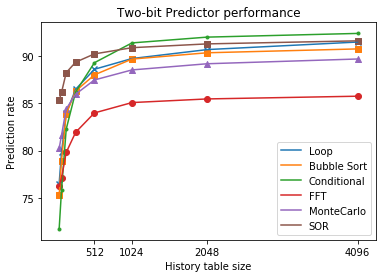

In [35]:
a = plot_graph("Two-bit Predictor performance", twobit_loop_data, twobit_sort_data, twobit_cond_data, twobit_fft_data, twobit_mc_data, twobit_sor_data)
a.plot()
plt.show()

In [58]:
c_loop_data = PlotData(c_loop, "Loop", "x")
c_cond_data = PlotData(c_cond, "Conditional", ".")
c_sort_data = PlotData(c_sort, "Bubble Sort", ",")
c_fft_data = PlotData(c_fft, "FFT", "o")
c_mc_data = PlotData(c_mc, "MonteCarlo", "^")
c_sor_data = PlotData(c_sor, "SOR", "s")

In [59]:
c_loop

[(32, 82.93546132864454),
 (64, 86.00121728545344),
 (128, 86.66170735556007),
 (256, 88.25995807127882),
 (512, 88.7288383940849),
 (1024, 88.70404183855189),
 (2048, 88.93848199995492),
 (4096, 88.91143121210072)]

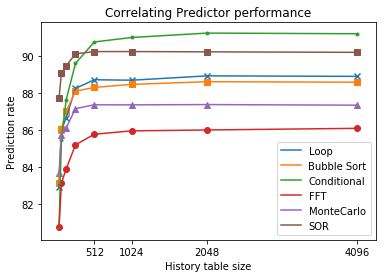

In [60]:
a = plot_graph("Correlating Predictor performance", c_loop_data, c_sort_data, c_cond_data, c_fft_data, c_mc_data, c_sor_data)
a.plot()
plt.show()

In [61]:
g_echo_data = PlotData(g_echo, "Echo", "x")
g_fft_data = PlotData(g_fft, "FFT", "o")
g_sor_data = PlotData(g_sor, "SOR", "s")
g_mc_data = PlotData(g_mc, "MonteCarlo", "^")
g_sort_data = PlotData(g_sort, "Bubble Sort", ",")
g_loop_data = PlotData(g_loop, "Loop", ".")
g_cond_data = PlotData(g_cond, "Condition", "*")

In [62]:
g_sort_data.data

[(64, 79.32465543644717),
 (128, 83.30321592649311),
 (256, 86.52833078101072),
 (512, 87.74272588055129),
 (1024, 88.24196018376723),
 (2048, 88.4364471669219),
 (4096, 88.52220520673814)]

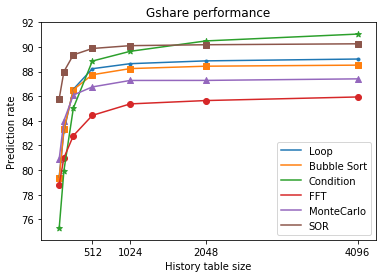

In [63]:
a = plot_graph("Gshare performance", g_loop_data, g_sort_data, g_cond_data, g_fft_data, g_mc_data, g_sor_data)
a.plot()
plt.show()

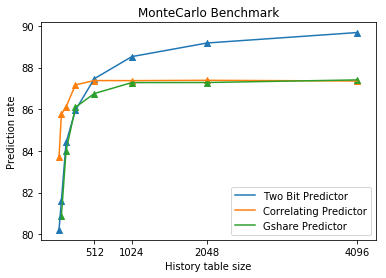

In [64]:
twobit_mc_data.label = "Two Bit Predictor"
c_mc_data.label = "Correlating Predictor"
g_mc_data.label = "Gshare Predictor"

a = plot_graph("MonteCarlo Benchmark", twobit_mc_data, c_mc_data, g_mc_data)
a.plot()
plt.show()

In [ ]:
twobit_cond_data.label = "Two Bit Predictor"
c_cond_data.label = "Correlating Predictor"
g_cond_data.label = "Gshare Predictor"

a = plot_graph("Loop condition benchmark", twobit_cond_data, c_cond_data, g_cond_data)
a.plot()
plt.show()

In [ ]:
correlating_histories = [CorrelatingPredictor(12, 2), CorrelatingPredictor(12, 3), CorrelatingPredictor(12, 4), CorrelatingPredictor(12, 5), CorrelatingPredictor(12, 6), CorrelatingPredictor(12, 7), CorrelatingPredictor(12, 8), CorrelatingPredictor(12, 9), CorrelatingPredictor(12, 10)], CorrelatingPredictor(12, 11), CorrelatingPredictor(12, 12)
ch_echo = []
ch_fft = []
ch_sor = []
ch_mc = []
ch_loop = []
ch_cond = []
ch_sort = []

for p in correlating_histories:
    print(p)
    


# References
- http://web.cs.ucdavis.edu/~su/Berkeley/cs252/project.html
- https://www2.eecs.berkeley.edu/Pubs/TechRpts/1983/CSD-83-121.pdf
- http://web.engr.oregonstate.edu/~benl/Projects/branch_pred/
- http://www.hpl.hp.com/techreports/Compaq-DEC/WRL-TN-36.pdf
- http://math.nist.gov/scimark2/about.html
- https://dl.acm.org/citation.cfm?id=192727
